# [Sartorius - Cell Instance Segmentation](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Detect single neuronal cells in microscopy images

![](https://storage.googleapis.com/kaggle-competitions/kaggle/30201/logos/header.png?t=2021-09-03-15-27-46)

# ⚽ Goal
📌 The purpose of this notebook is to show how to achieve Good score even using **UNet**. 

📌 Even though the competition is about **Instance Segmentation** we can use **UNet** do **Semantic Segmentation** and then convert them to individual **Instances**.

📌 Finally, we can use **UNet** with **Mask-RCNN** for Ensemble to further boost our score.

<img src="https://i.stack.imgur.com/MEB9F.png" width=800>

# 🚩 Version Info
* `v17`: trying new augmentation variants
    * normalization is off
    * optical-distortion is off
    * distortion prob=`0.25`
    * rotation range=`90`
    * coarse-dropout size is reduced to `img_size//20`
    * clahe augmentation is added
    * backbone: `efficientnet-b0`

# 📒 Notebooks
📌 **UNet**:
* Train: [[PyTorch] Sartorius: UNet Strikes Back [Train] 🔥](https://www.kaggle.com/awsaf49/pytorch-sartorius-unet-strikes-back-train/edit)
* Infer: [[PyTorch] Sartorius: UNet Strikes Back [Infer] 🔥](https://www.kaggle.com/awsaf49/pytorch-sartorius-unet-strikes-back-infer/edit)

📌 **Mask-RCNN**:
* Train: [Sartorius: MMDetection [Train]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-train)
* Infer: [Sartorius: MMDetection [Infer]](https://www.kaggle.com/awsaf49/sartorius-mmdetection-infer)

## Please Upvote if you Find this Useful :)

# 🛠 Install Libraries

In [ ]:
!pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl
!pip install -qU wandb

# 📚 Import Libraries 

In [ ]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⭐ WandB

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of **W&B**:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.

In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

# ⚙️ Configuration 

In [ ]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Unet-effnetb2-512x512-aug2'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b2'
    train_bs      = 24
    valid_bs      = 48
    img_size      = [512, 512]
    epochs        = 50
    lr            = 5e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(100*6*1.8)
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = 32//train_bs
    n_fold        = 5
    num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    competition   = 'sartorius'
    _wandb_kernel = 'awsaf49'

# ❗ Reproducibility

In [ ]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

# 📖 Meta Data

In [ ]:
BASE_PATH  = '/kaggle/input/sartorius-cell-instance-segmentation'
BASE_PATH2 = '/kaggle/input/sartorius-binary-mask-dataset'

In [ ]:
# Train Data
df               = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = BASE_PATH + '/train/' + df['id'] + '.png'
tmp_df           = df.drop_duplicates(subset=["id", "image_path"]).reset_index(drop=True)
tmp_df["annotation"] = df.groupby("id")["annotation"].agg(list).reset_index(drop=True)
df               = tmp_df.copy()
df['mask_path']  = BASE_PATH2 + '/' + df['id'] + '.npy'
display(df.head(2))

# Test Data
test_df       = pd.DataFrame(glob(BASE_PATH+'/test/*'), columns=['image_path'])
test_df['id'] = test_df.image_path.map(lambda x: x.split('/')[-1].split('.')[0])

display(test_df.head(2))

## Class Distribution

In [ ]:
df.cell_type.value_counts().plot.bar()

# 📁 Create Folds

In [ ]:
skf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["cell_type"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold'])['id'].count())

# 🍚 Dataset

In [ ]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.img_paths  = df['image_path'].values
        try: # if there is no mask then only send images --> test data
            self.msk_paths  = df['mask_path'].values
        except:
            self.msk_paths  = None
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img      = cv2.imread(img_path)
        img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.msk_paths is not None:
            msk_path = self.msk_paths[index]
            msk      = np.load(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            msk      = np.expand_dims(msk, axis=0) # output_shape: (batch_size, 1, img_size, img_size)
            return img, msk
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            return img

# 🌈 Augmentations

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size),
#         A.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0,
#             ),
        A.CLAHE(p=0.35),
        A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=90, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
#             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ToTensorV2()], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size),
#         A.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0
#             ),
        ToTensorV2()], p=1.0)
}

# 🍰 DataLoader

In [ ]:
def prepare_loaders(fold):
    train_df = df[df.fold != fold].reset_index(drop=True)
    valid_df = df[df.fold == fold].reset_index(drop=True)
    
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs, 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [ ]:
train_loader, valid_loader = prepare_loaders(fold=0)

In [ ]:
imgs, msks = next(iter(train_loader))
imgs = imgs.permute((0, 2, 3, 1))
msks = msks.permute((0, 2, 3, 1))
imgs.size(), msks.size()

# 📈 Visualization

In [ ]:
def plot_batch(imgs, msks, size=3):
    for idx in range(size):
        plt.figure(figsize=(4*3, 5))

        plt.subplot(1, 3, 1); plt.imshow(imgs[idx])
        plt.title('image', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 2); plt.imshow(msks[idx])
        plt.title('mask', fontsize=15)
        plt.axis('OFF')

        plt.subplot(1, 3, 3); plt.imshow(imgs[idx]); plt.imshow(msks[idx], alpha=0.3)
        plt.title('overlay', fontsize=15)
        plt.axis('OFF')
        
        plt.tight_layout()
        plt.show()

In [ ]:
plot_batch(imgs, msks, size=3)

# 📦 Model


## UNet

<img src="https://miro.medium.com/max/875/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="600">

📌 **Pros**:
* Performs well even with smaller data
* Can be used with `imagenet` pretrain models

📌 **Cons**:
* Struggles with **edge** cases
* Semantic Difference in **Skip Connection**

In [ ]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [ ]:
# test
img = torch.randn(1, 3, *CFG.img_size).to(CFG.device)
img = (img - img.min())/(img.max() - img.min())
model = build_model()
model(img)

# 🔧 Loss Function

In [ ]:
JaccardLoss = smp.losses.JaccardLoss(mode='binary')
Jaccard     = smp.losses.JaccardLoss(mode='binary', from_logits=False)
Dice        = smp.losses.DiceLoss(mode='binary', from_logits=False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

def criterion(y_pred, y_true):
    return JaccardLoss(y_pred, y_true)

# 🚄 Training Function

In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=optimizer.param_groups[0]['lr'],
                        gpu_memory=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

# 👀 Validation Function

In [ ]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    TARGETS = []
    PREDS   = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        PREDS.append(nn.Sigmoid()(y_pred))
        TARGETS.append(masks)
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=optimizer.param_groups[0]['lr'],
                        gpu_memory=f'{mem:0.2f} GB')
    
    TARGETS = torch.cat(TARGETS,dim=0).to(torch.float32)
    PREDS   = (torch.cat(PREDS, dim=0)>0.5).to(torch.float32)
    val_dice    = 1. - Dice(TARGETS, PREDS).cpu().detach().numpy()
    val_jaccard = 1. - Jaccard(TARGETS, PREDS).cpu().detach().numpy()
    val_scores  = [val_dice, val_jaccard]
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# 🏃 Run Training

In [ ]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice  = -np.inf
    best_epoch = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                         device=CFG.device, 
                                                         epoch=epoch)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"{c_}Valid Dice Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            wandb.save(PATH)
            print(f"Model Saved{sr_}")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), PATH)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_dice))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

# 🔍 Optimizer

<img src="https://mlfromscratch.com/content/images/2019/12/saddle.gif" width=500>

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)

# ⚓ Scheduler
* **CosineAnnealingWarmRestarts**:

<img src="https://user-images.githubusercontent.com/20135989/68026469-cccc5200-fcea-11e9-9399-11e4a5a5eae3.png" width=500>

* **CosineAnnealingLR**:

<img src="https://www.researchgate.net/publication/343341777/figure/fig1/AS:919348742979584@1596201229282/The-cosine-annealing-leaning-rate-in-different-Tmax.png" width=500>

* **ReduceLROnPlateau**:

<img src="https://miro.medium.com/max/1400/1*L6Dq6AgpWwjRNzmJ8EsEVA.png" width=500>

* **ExponentialLR**:

<img src="https://miro.medium.com/max/1400/1*CgioTtU7G7mL202dL7CVfg.png" width=500>

In [ ]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [ ]:
scheduler = fetch_scheduler(optimizer)

# 🚅 Training

In [ ]:
for fold in range(CFG.n_fold):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    run = wandb.init(project='sartorius-public', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous='must',
                     name=f"fold-{fold}|dim-{CFG.img_size}|model-{CFG.model_name}",
                     group=CFG.exp_name,
                    )
    train_loader, valid_loader = prepare_loaders(fold=fold)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs if not CFG.debug else 2)
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))

# ✨ Overview

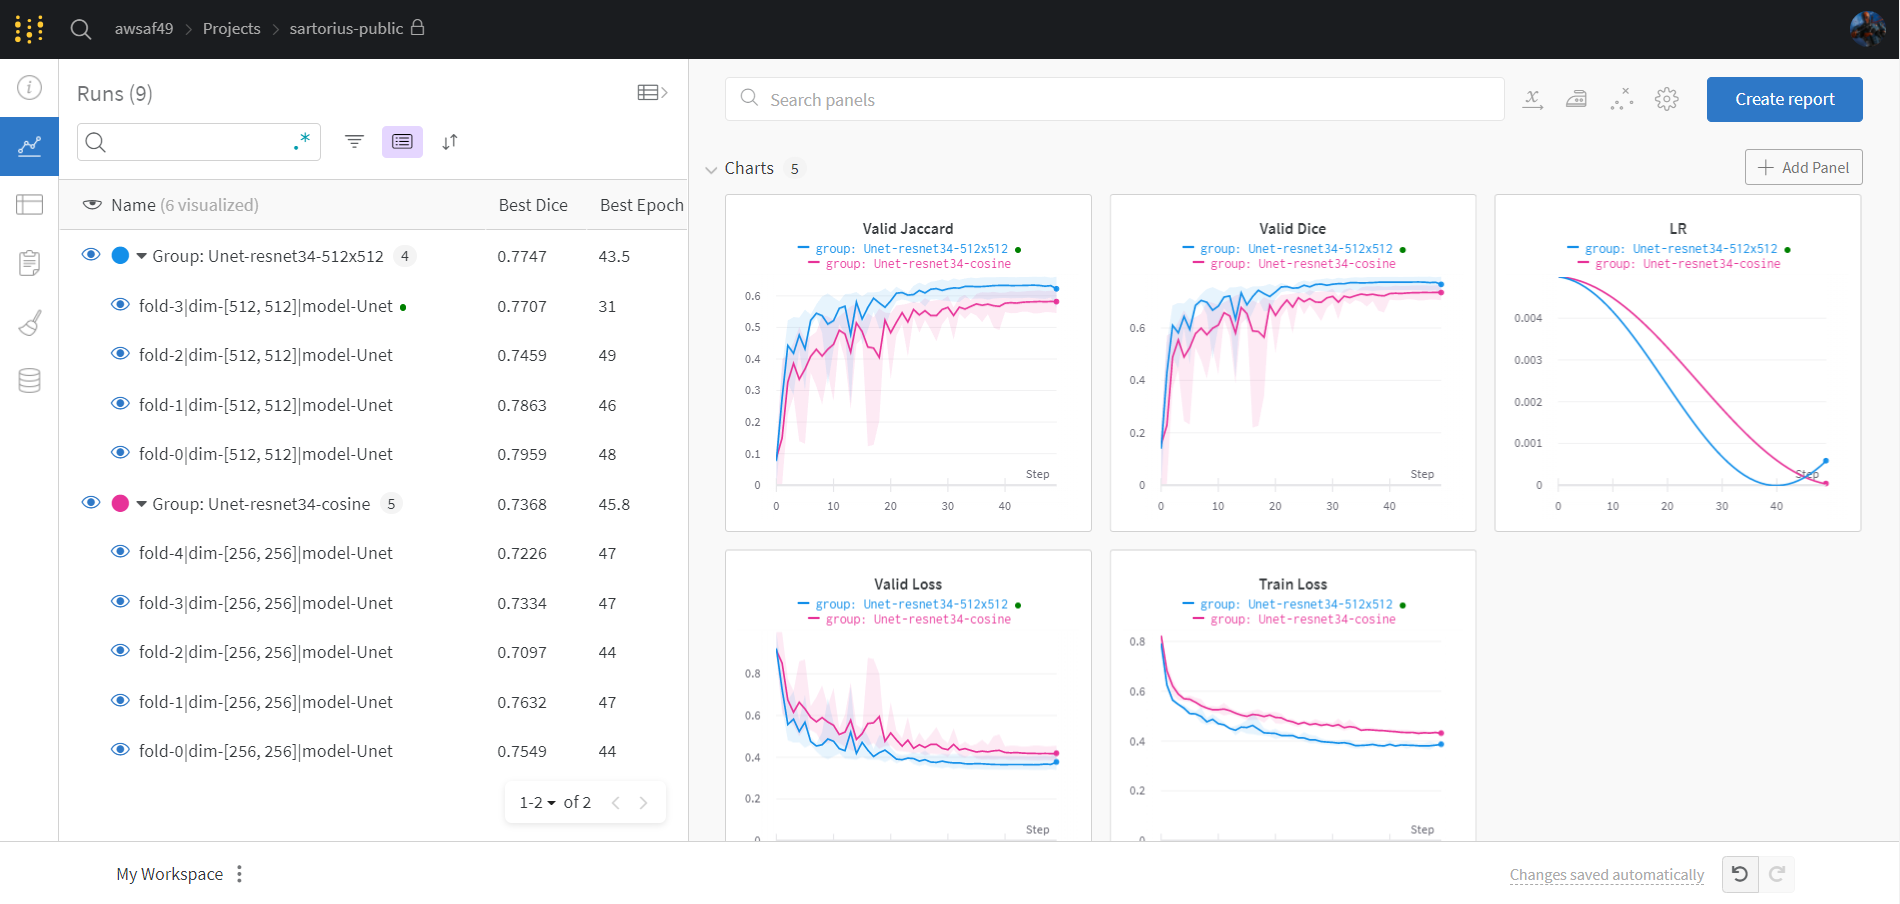

# 🔭 Prediction

In [ ]:
test_dataset = BuildDataset(test_df, transforms=data_transforms['valid'])
test_loader  = DataLoader(test_dataset, batch_size=3, 
                          num_workers=4, shuffle=False, pin_memory=True)
imgs = next(iter(test_loader))
imgs = imgs.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(CFG.n_fold):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(imgs)
        pred = nn.Sigmoid()(pred)
    preds.append(pred)
    
imgs  = imgs.permute((0,2,3,1)).cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).permute((0,2,3,1)).cpu().detach()

In [ ]:
plot_batch(imgs/255.0, preds)

# ✂️ Remove Files

In [ ]:
!rm -r ./wandb

# 💡 Reference
* [[Pytorch] Hybrid Swin Transformer + CNN](https://www.kaggle.com/debarshichanda/pytorch-hybrid-swin-transformer-cnn) by @debarshichanda